#### Imports

# Automated Software Improvement: A Machine Learning Solution
## Second Iteration - Prop Line Passed
### 2727141 Luke Skinner
### Supervisor: Dr Sandy Brownlee

## Overview

These notebooks contain all the work performed on the second iteration of the Machine Learning model(s) to help guide automated improvement of Software. The dataset provided for this iteration is "merged_stats_sb_17112020_iter2.csv" which is an aggregate of experimental results of edits performed on open source projects. This will include the second cycle of building an effective model. This cycle involved exploring Feature Construction, which used a tool called JavaParser, which allows the ability to parse and intrepret Java Source Files as a tree. This was used to create simple metrics, such as the number of nested if statements in a method. These were then used as new features to attempt to build a predictive model.

In [18]:
import seaborn as sns 
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
import numpy as np
import matplotlib as plt
from scipy.stats import loguniform
import statsmodels.api as sma

#### Utility Functions

In [19]:
def cacl_adj_r2(r2, n, k):
    """
    Calculates the adjusted r2 score based on the following formula:
    Adjusted r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1). This is used to
    complement the original r2 score to give a better understanding of
    how the model explains variance of the predictor variables

    Parameters:
        r2 (float): The original r2 score (from sklearn)
        n (int): The number of observations
        k (int): The number of predictor variables

    Returns:
        adj_r2 (float): The adjusted r2 score 
    """
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

def calc_p_value(X, y):
    X2 = sma.add_constant(X)
    
    return sma.OLS(y, X2)
    

#### Load Dataset

In [20]:
df = pd.read_csv('data/merged_stats_sb_17112020_iter2.csv')

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2157 entries, 0 to 2156
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CompositeKey                2157 non-null   object 
 1   Project                     2157 non-null   object 
 2   MethodIndex                 2157 non-null   int64  
 3   MethodName                  2157 non-null   object 
 4   numLines                    2157 non-null   int64  
 5   numStatements               2157 non-null   int64  
 6   EditDensity                 2157 non-null   float64
 7   AveUseDefDist               2157 non-null   float64
 8   NotDeclared                 2157 non-null   int64  
 9   AveUseDefDist/MethodLength  2157 non-null   float64
 10  MedDefUseDist               2157 non-null   float64
 11  MedUseDefDist/MethodLength  2157 non-null   float64
 12  CountLine                   2157 non-null   int64  
 13  CompiledLine                2157 

## Proposed Model with JavaParser Metrics 1 - Proportion Line Passed
## 1. Data Visualisation

In [21]:
df.corrwith(df['PropLinePassed']).drop('PropLinePassed')

MethodIndex                   0.213195
numLines                      0.110567
numStatements                 0.124634
EditDensity                  -0.033739
AveUseDefDist                 0.115697
NotDeclared                   0.006910
AveUseDefDist/MethodLength    0.066969
MedDefUseDist                 0.133223
MedUseDefDist/MethodLength    0.044016
CountLine                    -0.010677
CompiledLine                  0.078609
PassedLine                    0.129381
CountStat                    -0.010677
CompiledStat                  0.025546
PassedStat                    0.060022
PropLineCompiled              0.816889
PropStatCompiled              0.443489
PropStatPassed                0.563709
cyclomatic                    0.076494
ncss                          0.130679
npath                         0.011387
cyc/length                   -0.071027
ncss/length                   0.122020
npath/length                 -0.034211
InstCoverage-missed           0.075117
InstCoverage-covered     

## 2. Data Preparation

In [22]:
# Lets remove the non numerical fields as they are not useful for the model
df_new = df.drop(['CompositeKey', 'Project', 'MethodName', 'MethodIndex'], axis=1)

df_new.info() 

# We will filter out all rows which have a numLines < 10, we also want to only look at rows with sensible npath values
df_new = df_new[(df_new.numLines > 10) & (df.npath > -1)]

df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2157 entries, 0 to 2156
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   numLines                    2157 non-null   int64  
 1   numStatements               2157 non-null   int64  
 2   EditDensity                 2157 non-null   float64
 3   AveUseDefDist               2157 non-null   float64
 4   NotDeclared                 2157 non-null   int64  
 5   AveUseDefDist/MethodLength  2157 non-null   float64
 6   MedDefUseDist               2157 non-null   float64
 7   MedUseDefDist/MethodLength  2157 non-null   float64
 8   CountLine                   2157 non-null   int64  
 9   CompiledLine                2157 non-null   int64  
 10  PassedLine                  2157 non-null   int64  
 11  CountStat                   2157 non-null   int64  
 12  CompiledStat                2157 non-null   int64  
 13  PassedStat                  2157 

## 3. Beginning Train/Test split

##### We now want to identify the features which are most important, we will start by looking at all the other fields with respect to the target. First we will split the data 70%/30%.

In [23]:
X = df_new.drop(['PropLinePassed'], axis=1)

y = df_new['PropLinePassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
print(X_train.shape)

print(X_test.shape)

print(y_train.shape)

print(y_test.shape)

(647, 40)
(278, 40)
(647,)
(278,)


## 4. Feature Importances at a glance

##### To get the feature importances, we will first start by fitting an overall RandomForest model on the data and seeing what it produces as feature importances. This will not be the final model.

#### P Value of X, y

Let's take a look at some statistics, particurlary focusing on the P value. If it is less than 0.05 then we can reject the null hypothesis

In [24]:
p_value = calc_p_value(X, y)

print(p_value.fit().summary())

                            OLS Regression Results                            
Dep. Variable:         PropLinePassed   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     220.0
Date:                Wed, 07 Sep 2022   Prob (F-statistic):               0.00
Time:                        23:36:25   Log-Likelihood:                 1885.7
No. Observations:                 925   AIC:                            -3695.
Df Residuals:                     887   BIC:                            -3512.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

#### P Value of X_train, y_train

In [25]:
p_value = calc_p_value(X_train, y_train)

print(p_value.fit().summary())

                            OLS Regression Results                            
Dep. Variable:         PropLinePassed   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     181.4
Date:                Wed, 07 Sep 2022   Prob (F-statistic):          1.06e-301
Time:                        23:36:27   Log-Likelihood:                 1381.5
No. Observations:                 647   AIC:                            -2687.
Df Residuals:                     609   BIC:                            -2517.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

PassedLine                    0.447120
PropLineCompiled              0.444650
PropStatPassed                0.022963
CountLine                     0.017957
CountStat                     0.015291
CompiledStat                  0.006068
CompiledLine                  0.004024
MedUseDefDist/MethodLength    0.003466
EditDensity                   0.003453
ncss/length                   0.003298
dtype: float64


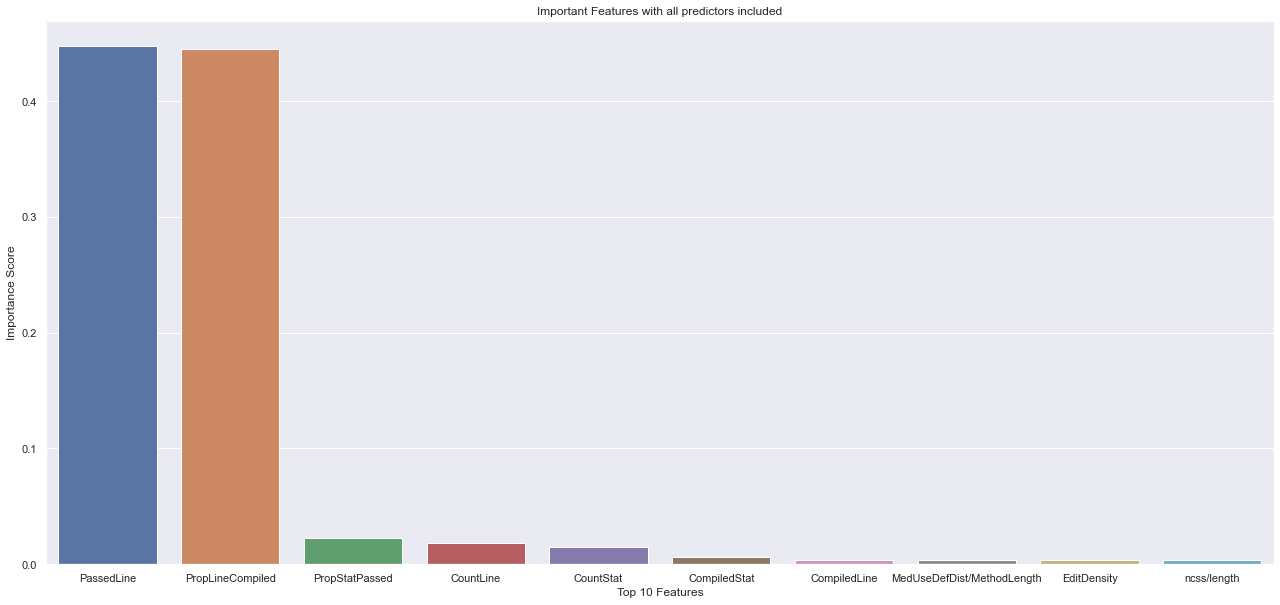

In [26]:
rforestreg = RandomForestRegressor()

rforestreg.fit(X_train, y_train)

feature_importances = pd.Series(rforestreg.feature_importances_, index=X.columns)

top_10 = feature_importances.nlargest(10)

bar_x = [i for i in range(len(top_10))]

sns.set(rc = {'figure.figsize' : (22, 10)})

ax = sns.barplot(x=bar_x, y=top_10)

ax.set(xlabel='Top 10 Features', ylabel='Importance Score', title='Important Features with all predictors included', xticklabels=top_10.index)

print(top_10)

## 5. Feature Selection

##### After getting the initial result with all features included, let's see what happens when we drop certain features, starting with PassedLine.

In [28]:
# Building a model with just the metrics
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length']]

y = df_new['PropLinePassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
print(X_train.shape)

print(X_test.shape)

print(y_train.shape)

print(y_test.shape)


(647, 8)
(278, 8)
(647,)
(278,)


#### P Value of X, y

In [29]:
p_value = calc_p_value(X, y)

print(p_value.fit().summary())

                            OLS Regression Results                            
Dep. Variable:         PropLinePassed   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     9.012
Date:                Wed, 07 Sep 2022   Prob (F-statistic):           5.83e-12
Time:                        23:36:48   Log-Likelihood:                 847.78
No. Observations:                 925   AIC:                            -1678.
Df Residuals:                     916   BIC:                            -1634.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0432      0.019      2.239

#### P Value of X_train, y_train

In [30]:
p_value = calc_p_value(X_train, y_train)

print(p_value.fit().summary())

                            OLS Regression Results                            
Dep. Variable:         PropLinePassed   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     6.633
Date:                Wed, 07 Sep 2022   Prob (F-statistic):           2.39e-08
Time:                        23:36:50   Log-Likelihood:                 602.92
No. Observations:                 647   AIC:                            -1188.
Df Residuals:                     638   BIC:                            -1148.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0510      0.022      2.277

ncss/length      0.183668
AveUseDefDist    0.167932
npath/length     0.140420
cyc/length       0.126789
ncss             0.122691
MedDefUseDist    0.116851
npath            0.075973
cyclomatic       0.065677
dtype: float64


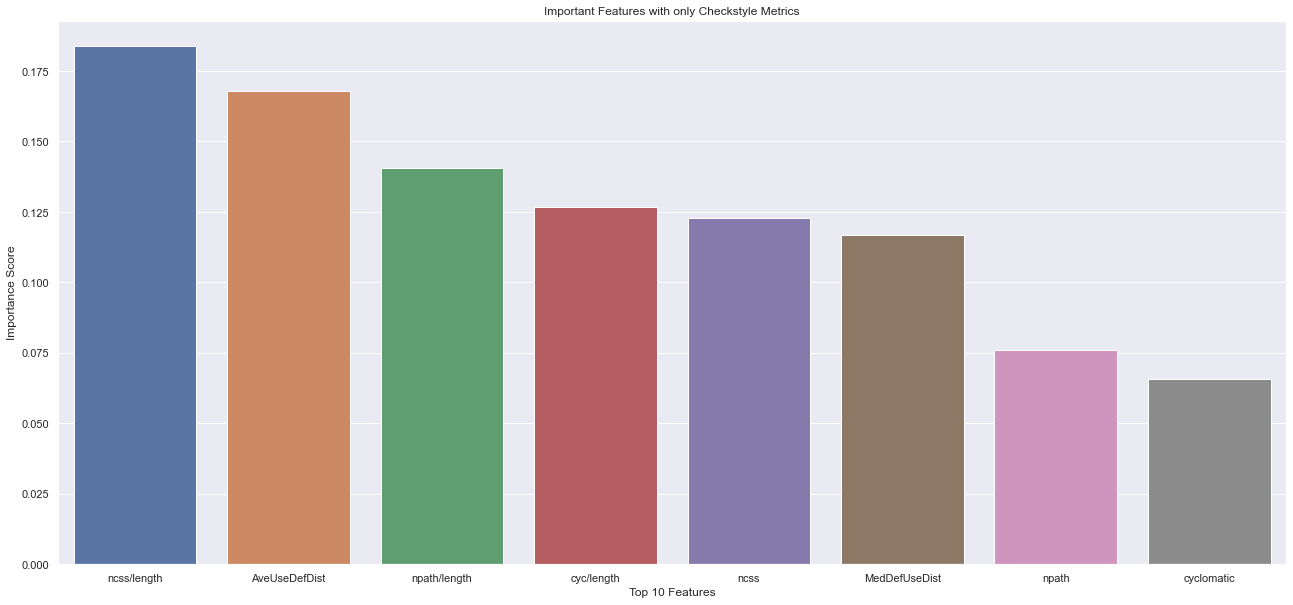

In [31]:
rforestreg = RandomForestRegressor()

rforestreg.fit(X_train, y_train)

feature_importances = pd.Series(rforestreg.feature_importances_, index=X.columns)

top_10 = feature_importances.nlargest(10)

bar_x = [i for i in range(len(top_10))]

sns.set(rc = {'figure.figsize' : (22, 10)})

ax = sns.barplot(x=bar_x, y=top_10)

ax.set(xlabel='Top 10 Features', ylabel='Importance Score', title='Important Features with only Checkstyle Metrics', xticklabels=top_10.index)

print(top_10)

In [32]:
y_pred = rforestreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.03864
Adj. R2: 0.03024
RMSE: 0.01027
MAE: 0.07570


In [33]:
# Building a model with just the metrics
X = df_new[['surfaceFors', 'nestedFors', 'surfaceIfs', 'nestedIfs', 'surfaceWhiles', 'nestedWhiles', 'surfaceDos','nestedDos','surfaceSwitches','nestedSwitches']]


y = df_new['PropLinePassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
print(X_train.shape)

print(X_test.shape)

print(y_train.shape)

print(y_test.shape)


(647, 10)
(278, 10)
(647,)
(278,)


#### P Value of X, y

In [34]:
p_value = calc_p_value(X, y)

print(p_value.fit().summary())

                            OLS Regression Results                            
Dep. Variable:         PropLinePassed   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     5.763
Date:                Wed, 07 Sep 2022   Prob (F-statistic):           1.94e-08
Time:                        23:36:58   Log-Likelihood:                 841.02
No. Observations:                 925   AIC:                            -1660.
Df Residuals:                     914   BIC:                            -1607.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1176      0.005     

#### P Value of X_train, y_train

In [35]:
p_value = calc_p_value(X_train, y_train)

print(p_value.fit().summary())

                            OLS Regression Results                            
Dep. Variable:         PropLinePassed   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     4.574
Date:                Wed, 07 Sep 2022   Prob (F-statistic):           2.74e-06
Time:                        23:37:00   Log-Likelihood:                 599.54
No. Observations:                 647   AIC:                            -1177.
Df Residuals:                     636   BIC:                            -1128.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1125      0.006     

AveUseDefDist    0.170279
MedDefUseDist    0.163584
ncss/length      0.152544
cyc/length       0.145908
npath/length     0.132806
ncss             0.116988
npath            0.064170
cyclomatic       0.050956
NotDeclared      0.002764
dtype: float64


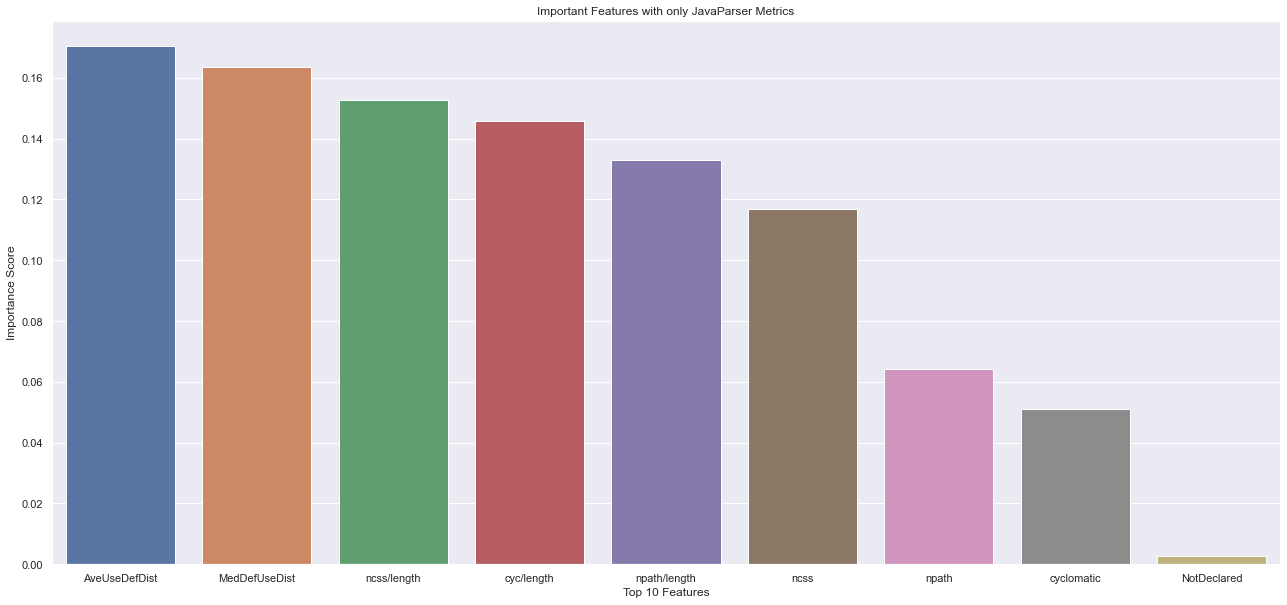

In [57]:
rforestreg = RandomForestRegressor()

rforestreg.fit(X_train, y_train)

feature_importances = pd.Series(rforestreg.feature_importances_, index=X.columns)

top_10 = feature_importances.nlargest(10)

bar_x = [i for i in range(len(top_10))]

sns.set(rc = {'figure.figsize' : (22, 10)})

ax = sns.barplot(x=bar_x, y=top_10)

ax.set(xlabel='Top 10 Features', ylabel='Importance Score', title='Important Features with only JavaParser Metrics', xticklabels=top_10.index)

print(top_10)

In [37]:
y_pred = rforestreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: -0.07132
Adj. R2: -0.08304
RMSE: 0.01145
MAE: 0.07875


## 6.1 Model Evaluation for model with JavaParser Metrics Only

### 6.1.1 Ridge Regression without Tuning

In [38]:
X = df_new[['surfaceFors', 'nestedFors', 'surfaceIfs', 'nestedIfs', 'surfaceWhiles', 'nestedWhiles', 'surfaceDos','nestedDos','surfaceSwitches','nestedSwitches']]

y = df_new['PropLinePassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
ridge = Ridge() 

ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")


R2 Score: 0.00150
Adj. R2: -0.00943
RMSE: 0.01067
MAE: 0.07606


### 6.1.2 Ridge Regression with Tuning

In [39]:
X = df_new[['surfaceFors', 'nestedFors', 'surfaceIfs', 'nestedIfs', 'surfaceWhiles', 'nestedWhiles', 'surfaceDos','nestedDos','surfaceSwitches','nestedSwitches']]

y = df_new['PropLinePassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
ridge = Ridge()

# Set up cross validation technique 
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Create Search space
space = dict()

space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']

space['alpha'] = loguniform(1e-5, 100)

space['fit_intercept'] = [True, False]

space['normalize'] = [True, False]

# Define search
search = RandomizedSearchCV(ridge, space, n_iter=800, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=1)

# Fit search
result = search.fit(X_train, y_train)

print('Best Score: %s' % result.best_score_)

print('Best Hyperparameters: %s' % result.best_params_)

print(ridge.get_params())

Best Score: -0.07297653003233133
Best Hyperparameters: {'alpha': 85.67288231521668, 'fit_intercept': True, 'normalize': False, 'solver': 'cholesky'}
{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}


C:\Users\lj\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [40]:
ridge = Ridge(solver='cholesky', fit_intercept=True, normalize=False, alpha=85.67288231521668)

ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.01124
Adj. R2: 0.00042
RMSE: 0.01056
MAE: 0.07577


C:\Users\lj\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


### 6.2 KNN without Tuning

In [41]:
X = df_new[['surfaceFors', 'nestedFors', 'surfaceIfs', 'nestedIfs', 'surfaceWhiles', 'nestedWhiles', 'surfaceDos','nestedDos','surfaceSwitches','nestedSwitches']]

y = df_new['PropLinePassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
knnreg = KNeighborsRegressor()

knnreg.fit(X_train, y_train)

y_pred = knnreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: -0.17456
Adj. R2: -0.18741
RMSE: 0.01255
MAE: 0.08348


### 6.2.2 KNN with Tuning

In [42]:
X = df_new[['surfaceFors', 'nestedFors', 'surfaceIfs', 'nestedIfs', 'surfaceWhiles', 'nestedWhiles', 'surfaceDos','nestedDos','surfaceSwitches','nestedSwitches']]

y = df_new['PropLinePassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
knnreg = KNeighborsRegressor()

# Set up cross validation technique 
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Create Search space
space = dict()

space['algorithm'] = ['ball_tree', 'kd_tree', 'brute']

space['n_neighbors'] = [2, 3, 5, 10, 12, 15, 20, 25, 30]

space['weights'] = ['uniform', 'distance']

space['leaf_size'] = [10, 30, 60, 80, 160, 320]

space['p'] = [1, 2, 3]

# Define search
search = RandomizedSearchCV(knnreg, space, n_iter=800, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=1)

# Fit search
result = search.fit(X_train, y_train)

print('Best Score: %s' % result.best_score_)

print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -0.07372860799189344
Best Hyperparameters: {'weights': 'uniform', 'p': 3, 'n_neighbors': 20, 'leaf_size': 60, 'algorithm': 'kd_tree'}


In [43]:
knnreg = KNeighborsRegressor(n_neighbors=20, weights='uniform', p=3, leaf_size=60, algorithm='kd_tree')

knnreg.fit(X_train, y_train)

y_pred = knnreg.predict(X_test)

r2 = r2_score(y_test, y_pred)
    
adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.01041
Adj. R2: -0.00042
RMSE: 0.01057
MAE: 0.07609


### 6.3.1 RandomForest without Tuning

In [44]:
X = df_new[['surfaceFors', 'nestedFors', 'surfaceIfs', 'nestedIfs', 'surfaceWhiles', 'nestedWhiles', 'surfaceDos','nestedDos','surfaceSwitches','nestedSwitches']]

y = df_new['PropLinePassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
rforestreg = RandomForestRegressor()

rforestreg.fit(X_train, y_train)

y_pred = rforestreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")
print(rforestreg.get_params())

R2 Score: -0.09039
Adj. R2: -0.10232
RMSE: 0.01165
MAE: 0.07938
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


### 6.3.2 RandomForest with Tuning

In [47]:
X = df_new[['surfaceFors', 'nestedFors', 'surfaceIfs', 'nestedIfs', 'surfaceWhiles', 'nestedWhiles', 'surfaceDos','nestedDos','surfaceSwitches','nestedSwitches']]

y = df_new['PropLinePassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
rforestreg = RandomForestRegressor()

# Set up cross validation technique 
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Create Search space
space = dict()

space['n_estimators'] = [100, 250, 300, 350, 400, 450, 500]

space['bootstrap'] = [True, False]

space['warm_start'] = [True, False]

space['ccp_alpha'] = loguniform(1e-5, 100)

# Define search
search = RandomizedSearchCV(rforestreg, space, n_iter=800, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=1)

# Fit search
result = search.fit(X_train, y_train)

print('Best Score: %s' % result.best_score_)

print('Best Hyperparameters: %s' % result.best_params_)


Best Score: -0.07337119898239258
Best Hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.00017114877263936507, 'n_estimators': 250, 'warm_start': True}


In [48]:
rforestreg = RandomForestRegressor(n_estimators = 250, warm_start=True, bootstrap=True, ccp_alpha=0.00017114877263936507)

rforestreg.fit(X_train, y_train)

y_pred = rforestreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.00445
Adj. R2: -0.00644
RMSE: 0.01064
MAE: 0.07617


### 6.4.1 MLPRegressor without Tuning

In [51]:
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length', 'NotDeclared']]

y = df_new['PropStatCompiled']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
mlpreg = MLPRegressor(max_iter=5500)

mlpreg.fit(X_train, y_train)

y_pred = mlpreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: -2.59974
Adj. R2: -2.63515
RMSE: 0.09549
MAE: 0.19779


### 6.4.2 MLPRegressor with Tuning

In [49]:
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length', 'NotDeclared']]

y = df_new['PropStatCompiled']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
mlpreg = MLPRegressor(max_iter=5500)

# Set up cross validation technique 
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Create Search space
space = dict()

space['hidden_layer_sizes'] = [(50,50,50), (50,100,50), (100,1), (100, 50, 1)]

space['activation'] = ['relu', 'tanh', 'logistic']

space['alpha'] = loguniform(1e-5, 100)

space['learning_rate'] = ['constant', 'adaptive']

space['solver'] = ['adam', 'lbfgs']

# Define search
random_search = RandomizedSearchCV(mlpreg, space, n_iter=10, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=1)

# Fit search
random_search_result = random_search.fit(X_train, y_train)
                     
print('Random Search Best Score: %s' % random_search_result.best_score_)

print('Random Search Best Hyperparameters: %s' % random_search_result.best_params_)


Random Search Best Score: -0.12255271915822442
Random Search Best Hyperparameters: {'activation': 'tanh', 'alpha': 0.48777805499545607, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}


In [53]:
mlpreg = MLPRegressor(activation='tanh', alpha=0.48777805499545607, hidden_layer_sizes=(50, 100, 50), learning_rate='constant', solver='adam')

mlpreg.fit(X_train, y_train)

y_pred = mlpreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.04713
Adj. R2: 0.03776
RMSE: 0.02528
MAE: 0.12380


C:\Users\lj\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
